### I did modular coding for this project
#### You can checkout my repo here https://github.com/aydiegithub/mr-helpmate-ai.git

#### I am still a college student and in the process of learning how to improve my skills. I hope my approach to this problem is correct. I have enhanced my modular approach by incorporating a new technique, adding LangGraph and a chunking method. This approach can be viewed on my repo.

## Loading All The Constants

In [1]:
import os
import dotenv
dotenv.load_dotenv()

GOOGLE_API_KEY: str = os.getenv("GOOGLE_API_KEY")
EMBEDDING_MODEL: str = "models/text-embedding-004"
MODEL: str = "gemini-2.5-flash"

CHROMA_API_KEY: str = os.getenv("CHROMA_API_KEY")
CHROMA_TENANT: str = os.getenv("CHROMA_TENANT")
CHROMA_DATABASE: str = os.getenv("CHROMA_DATABASE")
CHROMA_SERVER_HTTP_PORT: int = 443
CHROMA_SERVER_HOST: str = "api.trychroma.com"

COLLECTION_NAME: str = "insurance_data_mr_helpmate"
CACHE_COLLECTION_NAME: str = "query_insurance_data_mr_helpmate"

DISTANCE_THRESHOLD: float = 0.1

## Setting up ChromaDB Cloud Client

In [2]:
from src.constants import (
    CHROMA_API_KEY,
    CHROMA_DATABASE,
    CHROMA_TENANT,
)
import chromadb
from src.logging import Logger

logging = Logger()

class ChromaConnection:
    def __init__(self):
        """
        Initialize the ChromaConnection instance for ChromaDB Cloud using the official CloudClient.
        All configuration is read from src.constants (which loads .env via dotenv).
        """
        try:
            # Validate required configuration from constants
            missing = []
            if not CHROMA_API_KEY:
                missing.append("CHROMA_API_KEY")
            if not CHROMA_TENANT:
                missing.append("CHROMA_TENANT")
            if not CHROMA_DATABASE:
                missing.append("CHROMA_DATABASE")

            if missing:
                for var in missing:
                    logging.error(f"{var} is not set in src.constants.")
                raise ValueError(
                    "Missing required Chroma Cloud configuration. "
                    f"Set these in your .env so src.constants can load them: {', '.join(missing)}"
                )

            logging.info("Using Chroma tenant and database.")

            # Use the official Cloud client (recommended by Chroma docs)
            self.client = chromadb.CloudClient(
                api_key=CHROMA_API_KEY,
                tenant=CHROMA_TENANT,
                database=CHROMA_DATABASE,
            )
            logging.info("ChromaDB Cloud client initialized successfully.")

            # Verify existing collections (optional)
            existing = [c.name for c in self.client.list_collections()]
            logging.info(f"Existing collections in Chroma Cloud: {existing}")

        except Exception as e:
            logging.error(f"Failed to initialize ChromaDB Cloud client: {e}")
            raise

    def get_client(self):
        """Return the active ChromaDB client instance."""
        try:
            if not hasattr(self, "client") or self.client is None:
                logging.warning("ChromaDB client is not initialized.")
            return self.client
        except Exception as e:
            logging.error(f"Error accessing ChromaDB client: {e}")
            raise

    def get_or_create_collection(self, collection_name: str):
        """
        Retrieve or create a ChromaDB collection.
        """
        try:
            collection = self.client.get_or_create_collection(name=collection_name)
            logging.info(f"Collection '{collection_name}' retrieved or created.")
            return collection
        except Exception as e:
            logging.error(f"Error getting or creating collection '{collection_name}': {e}")
            raise

## PDF Extraction

In [3]:
import pdfplumber
from typing import Dict, Any
from src.logging import Logger

logging = Logger()

class Extractor:
    """
    Extractor class for extracting text and tables from PDF files.

    Methods
    -------
    content_extractor_node(file_path: str) -> Dict[str, Any]
        Extracts text and tables from each page of the PDF and returns the content as a dictionary.
    """

    def __init__(self):
        pass

    def content_extractor(self, file_path: str) -> str:
        """
        Extracts text and tables from each page of the PDF file.

        Parameters
        ----------
        file_path : str
            The path to the PDF file.

        Returns
        -------
        str
            A string containing the extracted content.
        """
        content = []
        try:
            logging.info(f"Opening PDF file: {file_path}")
            with pdfplumber.open(file_path) as pdf:
                for page_num, page in enumerate(pdf.pages, 1):
                    try:
                        page_text = page.extract_text()
                        if page_text:
                            content.append(page_text)
                        tables = page.extract_tables()
                        for t_idx, table in enumerate(tables, 1):
                            table_string = "\n".join(
                                ["\t".join(cell if cell is not None else "" for cell in row) for row in table]
                            )
                            content.append(table_string)
                    except Exception as e:
                        logging.warning(f"Failed to extract content from page {page_num}: {e}")
        except FileNotFoundError:
            logging.error(f"File not found: {file_path}")
            return ""
        except Exception as e:
            logging.error(f"Error opening or processing PDF file: {e}")
            return ""

        logging.info(f"Extraction completed for file: {file_path}")
        return "\n\n".join(content)

## Chunking Layer

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from src.logging import Logger

logging = Logger()

class TextChunking:
    def __init__(self):
        pass
    
    
    def create_chunks(self, input_text: str, 
                      chunk_size: int = 1200, 
                      overlap: int = 250) -> list[str]:
        """
        Splits the input text into chunks of specified size with overlap.

        Args:
            input_text (str): The text to be chunked.
            chunk_size (int, optional): The size of each chunk. Defaults to 1200.
            overlap (int, optional): The number of overlapping characters between chunks. Defaults to 250.

        Returns:
            list[str]: A list of text chunks.
        """
        try:
            logging.info(f"Starting text chunking with chunk_size={chunk_size}, overlap={overlap}")
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=overlap
            )
            chunks = text_splitter.split_text(input_text)
            logging.info(f"Text chunking successful. Number of chunks created: {len(chunks)}")
            if not chunks:
                logging.warning("No chunks were created from the input text.")
            return chunks

        except Exception as e:
            logging.error(f"Error during text chunking: {e}")
            return []


## Cache Checking

In [5]:
from src.constants import (
    CACHE_COLLECTION_NAME,
    GOOGLE_API_KEY,
    EMBEDDING_MODEL,
    DISTANCE_THRESHOLD,
)
from src.database.chromadb_connection import ChromaConnection
from google import generativeai as genai
from src.logging import Logger
from typing import Any, Dict, Tuple, List
import hashlib
import json

logging = Logger()
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY is not set.")
genai.configure(api_key=GOOGLE_API_KEY)

class CacheVectorStore:
    """
    Stores query embeddings in Chroma Cloud as a universal FAQ cache and allows retrieval.
    Each cache entry contains:
        - the query text
        - the query embedding
        - metadata (usually indexes of the main DB embeddings)
    """

    def __init__(
        self,
        collection_name: str = CACHE_COLLECTION_NAME,
        embedding_model: str = EMBEDDING_MODEL,
    ):
        try:
            logging.info("Initializing CacheVectorStore.")
            self.conn = ChromaConnection()
            self.collection = self.conn.get_or_create_collection(collection_name=collection_name)
            self.embedding_model = embedding_model
            logging.info("CacheVectorStore initialized successfully.")
        except Exception as exc:
            logging.error(f"Failed to initialize CacheVectorStore: {exc}")
            raise

    def _make_cache_id(self, query: str) -> str:
        """
        Create a stable ID for the cache entry based on the query text.
        """
        base = query.strip().lower().encode("utf-8")
        h = hashlib.md5(base).hexdigest()[:24]
        return f"q_{h}"

    def _sanitize_metadata(self, metadata: Dict[str, Any]) -> Dict[str, Any]:
        """
        Chroma Cloud metadata must be primitives (str, int, float, bool, None) or SparseVector.
        Convert lists/dicts to JSON strings with a _json suffix to remain queryable.
        """
        sanitized: Dict[str, Any] = {}
        for k, v in (metadata or {}).items():
            if v is None or isinstance(v, (str, int, float, bool)):
                sanitized[k] = v
            elif isinstance(v, (list, dict)):
                key = f"{k}_json" if not k.endswith("_json") else k
                try:
                    sanitized[key] = json.dumps(v)
                except Exception:
                    # Fallback to string if for some reason json fails
                    sanitized[key] = str(v)
                # Do NOT keep the original non-primitive under the same key
            else:
                sanitized[k] = str(v)
        return sanitized

    def check_query_in_cache(
        self,
        query_emb: List[float],
        threshold: float = DISTANCE_THRESHOLD,
    ) -> Tuple[bool, Dict[str, Any]]:
        """
        Checks if a similar query embedding exists in the cache.
        """
        logging.info("Checking if query exists in cache.")
        # Be explicit; avoid NumPy truthiness ambiguity
        if query_emb is None or (hasattr(query_emb, "__len__") and len(query_emb) == 0):
            logging.info("Empty query embedding supplied to cache lookup.")
            return False, {}

        if threshold <= 0:
            logging.info(f"Non-positive threshold provided {threshold}; using default {DISTANCE_THRESHOLD}.")
            threshold = DISTANCE_THRESHOLD

        try:
            results = self.collection.query(
                query_embeddings=[query_emb],
                n_results=1,
                include=["metadatas", "distances"],
            )

            if not results:
                logging.info("Chroma query returned no results.")
                return False, {}

            distances = results.get("distances") or []
            metadatas = results.get("metadatas") or []

            if not distances or not distances[0]:
                logging.info("No distance data returned for query.")
                return False, {}

            top_distance = distances[0][0]
            if top_distance >= threshold:
                logging.info(
                    f"Closest cached query distance ({top_distance}) exceeds threshold ({threshold})."
                )
                return False, {}

            metadata: Dict[str, Any] = {}
            if metadatas and metadatas[0]:
                raw_metadata = metadatas[0][0]
                if isinstance(raw_metadata, dict):
                    metadata = raw_metadata
                else:
                    logging.error(f"Unexpected metadata type from Chroma: {type(raw_metadata)}")
                    metadata = {"value": raw_metadata}

            logging.info(f"Cache hit found within threshold: {top_distance}")
            return True, metadata

        except Exception as exc:
            logging.error(f"Error checking query in cache: {exc}")
            return False, {}

    def update_cache(
        self,
        query: str,
        query_emb: List[float],
        metadata: Dict[str, Any],
    ) -> bool:
        """
        Updates the Chroma cache with a new query, embedding, and metadata.
        Returns True on success, False otherwise.
        """
        # Be explicit; avoid NumPy truthiness ambiguity
        if not query or query_emb is None or (hasattr(query_emb, "__len__") and len(query_emb) == 0) or not metadata:
            logging.warning("Empty query, embedding, or metadata; skipping cache update.")
            return False
        try:
            cache_id = self._make_cache_id(query)
            sanitized_meta = self._sanitize_metadata(metadata)
            self.collection.upsert(
                ids=[cache_id],
                documents=[query],
                embeddings=[query_emb],
                metadatas=[sanitized_meta],
            )
            logging.info(f"Cache updated successfully for query. id={cache_id}")
            return True
        except Exception as exc:
            logging.error(f"Error updating cache: {exc}")
            return False

/Users/poppinadityagmail.com/Developer/GitHub_Codes/mr-helpmate-ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Vector Embedding and DB Upsert, Query and Delete layer

In [6]:
from src.database.chromadb_connection import ChromaConnection
from src.database.chromadb_cache import CacheVectorStore
from google import generativeai as genai
from src.constants import (
    COLLECTION_NAME,
    EMBEDDING_MODEL,
    GOOGLE_API_KEY,
)
from src.logging import Logger
import hashlib
import json
from typing import Dict, List, Any

if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY is not set.")
genai.configure(api_key=GOOGLE_API_KEY)

logging = Logger()

class VectorStore:
    """
    Stores vector embeddings in Chroma Cloud and allows retrieval
    """
    def __init__(self, collection_name: str = COLLECTION_NAME, embedding_model: str = EMBEDDING_MODEL):
        try:
            logging.info("Initializing VectorStore.")
            self.conn = ChromaConnection()
            self.collection = self.conn.get_or_create_collection(collection_name=collection_name)
            self.embedding_model = embedding_model
            logging.info("VectorStore initialized successfully.")
        except Exception as exc:
            logging.error(f"Failed to initialize VectorStore: {exc}")
            raise

    def upsert_documents(self, documents: List[str] = None):
        """
        Generate embeddings and store documents in the vector collection
        """
        try:
            if not documents:
                logging.warning("No documents provided to add_documents.")
                return

            logging.info(f"Generating embeddings for {len(documents)} documents.")
            embeddings = [
                genai.embed_content(model=self.embedding_model, content=doc)["embedding"]
                for doc in documents
            ]

            ids_ = [self.generate_document_id(doc=doc, index=i) for i, doc in enumerate(documents)]

            logging.info("Upserting documents into the collection.")
            self.collection.upsert(
                documents=documents,
                embeddings=embeddings,
                ids=ids_,
            )
            logging.info("Documents added successfully.")
        except Exception as exc:
            logging.error(f"Failed to add documents: {exc}")
            raise

    def fetch_all_data(self, collection_name: str = COLLECTION_NAME, batch_size: int = 500) -> Dict[str, Any]:
        """
        Fetch all documents, IDs, embeddings, and metadatas from Chroma DB collection.
        Uses ID pagination to ensure embeddings come back even if the server limits payload size.
        """
        try:
            logging.info(f"Fetching all data from collection {collection_name}.")
            collection = self.conn.get_or_create_collection(collection_name=collection_name)

            # 'ids' are returned by default; do not put 'ids' in include
            ids_resp = collection.get() or {}
            all_ids = ids_resp.get("ids") or []
            if not all_ids:
                logging.info(f"No records found in collection {collection_name}.")
                return {"ids": [], "documents": [], "embeddings": [], "metadatas": []}

            agg_ids: List[str] = []
            agg_docs: List[str] = []
            agg_embs: List[List[float]] = []
            agg_metas: List[Dict[str, Any]] = []

            for start in range(0, len(all_ids), batch_size):
                batch_ids = all_ids[start:start + batch_size]
                batch = collection.get(
                    ids=batch_ids,
                    include=["documents", "embeddings", "metadatas"],
                ) or {}

                agg_ids.extend(batch.get("ids") or [])
                agg_docs.extend(batch.get("documents") or [])
                agg_embs.extend(batch.get("embeddings") or [])
                agg_metas.extend(batch.get("metadatas") or [])

            logging.info(
                f"Fetched {len(agg_docs)} documents, {len(agg_embs)} embeddings, {len(agg_metas)} metadatas from {collection_name}."
            )
            return {
                "ids": agg_ids,
                "documents": agg_docs,
                "embeddings": agg_embs,
                "metadatas": agg_metas,
            }
        except Exception as exc:
            logging.error(f"Failed to fetch all data from collection {collection_name}: {exc}")
            raise

    def _extract_ids_from_cached_meta(self, cached_meta: Dict[str, Any]) -> List[str]:
        """
        Supports multiple ways of storing IDs in cache metadata:
          - ids as list (if ever allowed)
          - ids_json as JSON string
          - ids_csv as comma-separated string
        """
        if not isinstance(cached_meta, dict):
            return []
        ids = cached_meta.get("ids")
        if isinstance(ids, list):
            return ids
        if "ids_json" in cached_meta and isinstance(cached_meta["ids_json"], str):
            try:
                parsed = json.loads(cached_meta["ids_json"])
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass
        if "ids_csv" in cached_meta and isinstance(cached_meta["ids_csv"], str):
            return [x for x in cached_meta["ids_csv"].split(",") if x]
        return []

    def query_from_db(self, query: str = "", top_k: int = 10) -> Dict[str, Any]:
        """
        Query vector store using embeddings of the query.
        Workflow:
          - Embed query
          - Cache check (distance < threshold => hit)
          - If hit: fetch by IDs from main collection
          - If miss: query main collection and cache top IDs
        """
        try:
            if not query:
                logging.warning("Empty query received.")
                return {}

            logging.info(f"Querying content with top_k={top_k}.")
            query_embedding = genai.embed_content(model=self.embedding_model, content=query)["embedding"]

            cache_vectorstore = CacheVectorStore()

            cache_status, cached_meta = cache_vectorstore.check_query_in_cache(query_embedding)

            if cache_status:
                logging.info(f"Query found in cache: {query}")
                ids = self._extract_ids_from_cached_meta(cached_meta)
                if ids:
                    # Fetch by IDs from the main collection
                    return self.collection.get(ids=ids, include=["documents", "metadatas"])

            logging.info("Query not found in cache.")
            # Do not include 'ids' here; Chroma returns 'ids' by default for query
            result = self.collection.query(
                query_embeddings=[query_embedding],
                n_results=top_k,
                include=["documents", "metadatas", "distances", "embeddings"],
            )
            logging.info("Query completed successfully.")

            top_ids = result.get("ids", [[]])[0] if result.get("ids") else []
            if top_ids:
                # Store IDs under a JSON-serialized metadata key to satisfy Chroma type constraints
                success = cache_vectorstore.update_cache(
                    query=query,
                    query_emb=query_embedding,
                    metadata={"ids_json": json.dumps(top_ids)},
                )
                if success:
                    logging.info(f"Query cached with {len(top_ids)} ids.")
                else:
                    logging.info("Cache update failed; skipping success log.")
            else:
                logging.info("No IDs returned to cache; skipping cache update.")

            return result
        except Exception as exc:
            logging.error(f"Failed to query content: {exc}")
            raise

    def delete_documents(self, id: List[str] = None, delete_all: bool = False, confirm_delete_all: bool = False):
        """
        Delete documents from the collection by ID or delete all documents.
        """
        try:
            if delete_all:
                if not confirm_delete_all:
                    logging.warning("confirm_delete_all=False. Set it to True to delete all documents.")
                    return
                logging.info("Deleting all documents from the collection.")
                self.collection.delete()
                logging.info("All documents deleted successfully.")
                return

            if id:
                logging.info(f"Deleting documents with IDs: {id}")
                self.collection.delete(ids=id)
                logging.info(f"Documents {id} deleted successfully.")
                return

            logging.warning("No ID provided and delete_all=False. Nothing was deleted.")

        except Exception as exc:
            logging.error(f"Failed to delete documents: {exc}")
            raise

    def generate_document_id(self, doc: str, index: int = 1) -> str:
        """
        Generate deterministic string ID with suffix n1, n2, etc.
        """
        doc_bytes = doc.encode("utf-8")
        hash_object = hashlib.md5(doc_bytes)
        hash_int = int(hash_object.hexdigest(), 16)
        hash_str = str(hash_int)[:9]
        return f"{hash_str}n{index}"

## Independent Embedding layer

In [7]:
from src.logging import Logger
import chromadb
import chromadb.config
import os
from google import generativeai as genai
from src.constants import GOOGLE_API_KEY, EMBEDDING_MODEL
import hashlib


logging = Logger()
genai.configure(api_key=GOOGLE_API_KEY)
chromadb_collection = chromadb.api.models.Collection.Collection

class VectorEmbedding():
    """
    Handles embedding generation and persistence using ChromaDB and Gemini API.
    Supports both persistent and in-memory ChromaDB clients.
    """

    def __init__(self, persistence: bool = True, persist_directory: str = "chromadb_collections"):
        """
        Initializes the VectorEmbedding class with a ChromaDB client.
        If persistence is True, uses persistent storage at 'chromadb_collections'.
        Otherwise, uses an in-memory client without persistence.

        Args:
            persistence (bool, optional): Whether to persist data to disk. Defaults to True.
        """
        try:
            if persistence:
                logging.info(f"Initializing ChromaDB client with persistent storage at {persist_directory}.")
                self.chroma_client = chromadb.Client(chromadb.config.Settings(
                    persist_directory=persist_directory
                ))
                logging.info("ChromaDB client initialized successfully with persistence.")
            else:
                logging.info("Initializing ChromaDB client in-memory without persistence.")
                self.chroma_client = chromadb.Client()  # <- FIXED
                logging.info("ChromaDB client initialized successfully in-memory.")
        except Exception as e:
            logging.error(f"Error initializing ChromaDB client: {e}")
            raise

    def generate_embedding(
        self,
        collection_name: str = 'default',
        documents: list[str] | None = None,
        ids: list[str] | None = None
    ) -> chromadb_collection:
        """
        Generates embeddings for the provided documents using Gemini API and upserts them into ChromaDB.

        Args:
            collection_name (str, optional): The name of the ChromaDB collection. Defaults to 'default'.
            documents (list[str], optional): List of documents to embed. Defaults to [''].
            ids (list[str], optional): List of document IDs. If not provided, generated automatically.

        Returns:
            chromadb.api.models.Collection.Collection: The ChromaDB collection with the upserted documents.
        """
        try:
            if not documents:
                documents = ['']

            logging.info(f"Getting or creating ChromaDB collection: {collection_name}")
            collection = self.chroma_client.get_or_create_collection(name=collection_name)

            embeddings = []
            for idx, doc in enumerate(documents):
                try:
                    logging.info(f"Generating embedding for document {idx}")
                    emb_response = genai.embed_content(model=EMBEDDING_MODEL, content=doc)
                    embeddings.append(emb_response["embedding"])
                except Exception as e:
                    logging.error(f"Embedding generation failed for document {idx}: {e}")
                    embeddings.append([])
                    
            if not ids:
                ids = [self.generate_document_id(doc=doc, index=id) for id, doc in enumerate(documents)]

            logging.info(f"Upserting {len(documents)} documents into collection '{collection_name}'")
            collection.upsert(
                documents=documents,
                embeddings=embeddings,
                ids=ids
            )

            logging.info("Embedding generation and upsert completed successfully.")
            return collection

        except Exception as e:
            logging.error(f"Error during embedding generation or upsert: {e}")
            raise

    def save_collection(self, db_path: str = "chromadb_collections"):
        """
        Persists the ChromaDB collections to disk.

        Args:
            db_path (str, optional): The directory path to save the collections. Defaults to "chromadb_collections".
        """
        try:
            logging.info(f"Saving collection to {db_path}")
            if not os.path.exists(db_path):
                os.makedirs(db_path)
                logging.info(f"Created directory {db_path} for collection persistence.")
            self.chroma_client.persist()
            logging.info(f"Collection saved successfully at {db_path}")
        except Exception as e:
            logging.error(f"Error saving collection: {e}")
            
    
    def delete_documents(self, 
                         id: list[str] = None, 
                         delete_all: bool = False, 
                         confirm_delete_all: bool = False):
        """
        Delete documents from the collection by ID or delete all documents.

        Args:
            id (list[str], optional): List of document IDs to delete.
            delete_all (bool, optional): If True, deletes all documents. Defaults to False.
            confirm_delete_all (bool, optional): Must be True to confirm delete_all. Defaults to False.
        """
        try:
            if delete_all:
                if not confirm_delete_all:
                    logging.warning("confirm_delete_all=False. Set it to True to delete all documents.")
                    return
                logging.info("Deleting all documents from all collections.")
                for collection in self.chroma_client.list_collections():
                    coll_obj = self.chroma_client.get_collection(collection.name)
                    coll_obj.delete()
                logging.info("All documents deleted successfully.")
                return

            if id:
                logging.info(f"Deleting documents with IDs: {id}")
                for collection in self.chroma_client.list_collections():
                    coll_obj = self.chroma_client.get_collection(collection.name)
                    coll_obj.delete(ids=id)
                logging.info(f"Documents {id} deleted successfully.")
                return

            logging.warning("No ID provided and delete_all=False. Nothing was deleted.")

        except Exception as exc:
            logging.error(f"Failed to delete documents: {exc}")
            raise
            
    def generate_document_id(self, doc: str, index: int = 1) -> str:
        """
        Generate deterministic numeric ID with suffix n1, n2, etc.
        
        Args:
            doc (str): The document content
            index (int): Index for uniqueness (default 1)
        
        Returns:
            str: Generated ID, e.g., 748837283n1
        """
        doc_bytes = doc.encode("utf-8")
        
        hash_object = hashlib.md5(doc_bytes)
        
        hash_int = int(hash_object.hexdigest(), 16)
        hash_str = str(hash_int)[:9]
        
        generated_id = f"{hash_str}n{index}"
        
        return generated_id

## Rerank Layer using Cross Encoder and Sklearn manual

In [8]:
import heapq 

from sentence_transformers import CrossEncoder
from src.logging import Logger
import google.generativeai as genai
from src.constants import (GOOGLE_API_KEY, 
                           EMBEDDING_MODEL)
from sklearn.metrics.pairwise import cosine_similarity

logging = Logger()
genai.configure(api_key=GOOGLE_API_KEY)

class Reranker():
    def __init__(self):
        try:
            logging.info("Initializing Reranker with cross-encoder model")
            self.cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
        except Exception as e:
            logging.error(f"Failed to initialize Reranker: {str(e)}")
            raise
    
    def rerank_documents(self, 
                         documents: list[str] = None,
                         embeddings: list[list[float]] = None,
                         query: str = None,
                         cross_encoder: bool = True,
                         top_k: int = 3) -> list[list[float, str]]:
        """
        Rerank documents using either cross-encoder or cosine similarity method.
        Args:
            documents: List of document strings
            embeddings: List of document embeddings
            query: Query string
            cross_encoder: Whether to use cross-encoder for reranking
            top_k: Number of top documents to return
        Returns:
            List of reranked documents
        """
        try:
            logging.info(f"Reranking documents with {'cross-encoder' if cross_encoder else 'cosine similarity'}")
            
            if cross_encoder:
                if documents is None or query is None:
                    logging.warning("Documents or query is None for cross-encoder reranking")
                    return []
                return self.rerank_with_cross_encoders(documents=documents, query=query, top_k=top_k)
            
            if documents is None or embeddings is None or query is None:
                logging.warning("Documents, embeddings, or query is None for cosine similarity reranking")
                return []
            return self.rerank_with_cosine_similarity(documents=documents, embeddings=embeddings, query=query, top_k=top_k)
            
        except Exception as e:
            logging.error(f"Error in rerank_documents: {str(e)}")
            raise
        
    def rerank_with_cross_encoders(self, 
                                   documents: list[str] = None,
                                   query: str = None,
                                   top_k: int = 3) -> list[list[float, str]]:
        """
        Rerank documents using cross-encoder model.
        Args:
            documents: List of document strings
            query: Query string
            top_k: Number of top documents to return
        Returns:
            List of [score, document] pairs sorted by score
        """
        try:
            logging.info(f"Reranking {len(documents)} documents with cross-encoder")
            hq_document = []
            for doc in documents:
                score = self.cross_encoder.predict([doc, query])
                heapq.heappush(hq_document, (score, doc))
                if len(hq_document) > top_k:
                    heapq.heappop(hq_document)

            top_docs = sorted(hq_document, key=lambda x: x[0], reverse=True)
            logging.info(f"Successfully reranked documents with cross-encoder")
            return [[score, doc] for score, doc in top_docs]
        except Exception as e:
            logging.error(f"Error in rerank_with_cross_encoders: {str(e)}")
            raise
    
    def rerank_with_cosine_similarity(self,
                                      documents: list[str] = None, 
                                      embeddings: list[list[float]] = None,
                                      query: str = None,
                                      top_k: int = 3) -> list[list[float, str]]:
        """
        Rerank documents using cosine similarity.
        Args:
            documents: List of document strings
            embeddings: List of document embeddings
            query: Query string
            top_k: Number of top documents to return
        Returns:
            List of [score, document] pairs sorted by score
        """
        try:
            if documents is None or embeddings is None or query is None:
                logging.warning("Missing required inputs for cosine similarity reranking")
                return []
                
            logging.info(f"Reranking {len(documents)} documents with cosine similarity")
            query_embedding_response = genai.embed_content(model=EMBEDDING_MODEL, content=query)
            query_embedding = query_embedding_response.get("embedding", query_embedding_response)
            
            hq_document = []
            for emb, doc in zip(embeddings, documents):
                score = cosine_similarity([query_embedding], [emb])[0][0]
                heapq.heappush(hq_document, (score, doc))
                if len(hq_document) > top_k:
                    heapq.heappop(hq_document)

            top_docs = sorted(hq_document, key=lambda x: x[0], reverse=True)
            logging.info(f"Successfully reranked documents with cosine similarity")
            return [[score, doc] for score, doc in top_docs]
        except Exception as e:
            logging.error(f"Error in rerank_with_cosine_similarity: {str(e)}")
            raise

## Intent Check and Moderation Layer

In [9]:
from src.constants import GOOGLE_API_KEY, MODEL
from src.artifacts import ModerationCheckPrompt, IntentConfirmationPrompt
from src.logging import Logger
import json
from openai import OpenAI

logging = Logger()

client = OpenAI(
    api_key=GOOGLE_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

class ModerationCheck:
    def __init__(self):
        self.moderation_prompt = ModerationCheckPrompt.prompt
        logging.info("ModerationCheck initialized")

    def check_moderation(self, input_message: str = "") -> bool:
        """
        Returns True if content is UNSAFE (bad), False if SAFE.
        Policy:
        - Empty input => False (safe)
        - finish_reason == 'content_filter' => True (unsafe/bad)
        - Non-empty text => False (safe)
        - No text and no explicit filter => False (safe)
        - On errors => True (treat as unsafe to fail closed)
        """
        try:
            logging.info(f"Starting moderation check for message: {input_message[:50]}...")
            if not input_message.strip():
                logging.warning("Empty input for moderation check.")
                return False  # safe
            response = client.chat.completions.create(
                model=MODEL,
                messages=[
                    {"role": "system", "content": self.moderation_prompt},
                    {"role": "user", "content": input_message}
                ]
            )
            message_content = response.choices[0].message.get("content") if hasattr(response.choices[0].message, "get") else getattr(response.choices[0].message, "content", "")
            logging.info(f"Intent for {input_message} is {message_content}")
            if message_content.lower() in ["flagged"]:
                return True
            return False

        except Exception as e:
            logging.error(f"Error during moderation check: {e}")
            return True


class IntentCheck:
    def __init__(self):
        self.intent_confirmation_prompt = IntentConfirmationPrompt.prompt
        logging.info("IntentCheck initialized")

    def check_intent(self, input_message: str = "") -> bool:
        """
        Returns True if intent is confirmed, False otherwise.
        Policy:
        - Empty input => False
        - finish_reason == 'content_filter' => False
        - Parse returned text for affirmative keywords
        """
        try:
            logging.info(f"Starting moderation check for message: {input_message[:50]}...")
            if not input_message.strip():
                logging.warning("Empty input for moderation check.")
                return False  
            response = client.chat.completions.create(
                model=MODEL,
                messages=[
                    {"role": "system", "content": self.intent_confirmation_prompt},
                    {"role": "user", "content": input_message}
                ]
            )
            message_content = response.choices[0].message.get("content") if hasattr(response.choices[0].message, "get") else getattr(response.choices[0].message, "content", "")
            logging.info(f"Intent for {input_message} is {message_content}")
            if message_content.lower() in ["true"]:
                return True
            return False

        except Exception as e:
            logging.error(f"Error during intent check: {e}")
            return True

## Chat Completion and Generation

In [10]:
from src.constants import GOOGLE_API_KEY, MODEL
from src.artifacts import SystemInstruction
from src.logging import Logger
from typing import Dict
import json
from openai import OpenAI

logging = Logger()

client = OpenAI(
    api_key=GOOGLE_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

class ChatCompletion():
    def __init__(self):
        self.system_instruction = SystemInstruction.prompt
        
    def chat_completion(self, messages: list[Dict[str, str]] = None) -> str:
        try:
            logging.info(f"Starting chat_completion")
            if not messages:
                logging.warning("Empty messages for chat_completion.")
                return ""
            
            response = client.chat.completions.create(
                model=MODEL,
                messages=messages
            )
            message_content = response.choices[0].message.get("content") if hasattr(response.choices[0].message, "get") else getattr(response.choices[0].message, "content", "")
            logging.info(f"Gemini response {message_content}")
            return message_content

        except Exception as e:
            logging.error(f"Error during moderation check: {e}")
            raise

## System Prompts

In [11]:
from dataclasses import dataclass

@dataclass
class SystemInstruction:
    prompt: str = f"""
        You are an smart insurance and banking agent.

    Role:
    - You are a strict Assistant for insurance, banking, and finance.
    - You MUST answer ONLY with information explicitly present in the provided Context.
    - You MUST NOT use outside knowledge, guess, speculate, or invent details.

    Inputs:
    - Context: `{{context}}`  (may be empty)
    - Question: `{{question}}`

    Hard constraints:
    1) Domain gating:
    - If the Question is NOT about insurance, banking, or finance, respond exactly: "I don't have an answer."
    2) Context gating:
    - If Context is empty OR does not contain the information needed to answer the Question, respond exactly: "I don't have an answer."
    3) Grounding:
    - Use only facts verbatim from Context. You may paraphrase for clarity, but do not add new facts.
    - Do not infer missing values. Do not generalize. Do not answer from general world knowledge.
    4) Style:
    - Keep it simple, clear, and human-friendly.
    - Use a short paragraph or up to 5 concise bullet points.
    - No disclaimers about context or retrieval. Do not mention these rules.
    - No citations, links, or references unless they appear literally in Context.
    5) Forbidden content:
    - No stories, poems, jokes, roleplay, or creative writing.
    - No code, pseudo-code, formulas, or shell commands.
    - No legal, tax, or investment advice beyond what is explicitly in Context.
    - No hypotheticals, future predictions, or assumptions.
    6) Output format:
    - If answerable from Context and in-domain: provide the short answer.
    - Otherwise: exactly "I don't have an answer."

    Allowed minimal reasoning:
    - You may perform minimal arithmetic directly implied by Context (e.g., adding clearly stated fees) without introducing new assumptions.
    - If arithmetic is not clearly implied, do not compute—respond: "I don't have an answer."

    Decision process (apply in order):
    A) Is the Question about insurance, banking, or finance?
    - If NO → "I don't have an answer."
    B) Does Context contain the specific information needed to answer?
    - If NO or Context is empty → "I don't have an answer."
    C) Answer briefly and clearly using only Context.

    Few-shot examples:

    Example 1 (answerable; insurance):
    Context:
    - The Gold Health Plan covers inpatient hospitalization up to $50,000 per policy year.
    - The deductible is $500 per member per year.
    - Coinsurance is 20% after deductible.

    Question:
    What is the deductible on the Gold Health Plan?

    Assistant:
    $500 per member per year.

    Example 2 (missing info in-domain):
    Context:
    - The Gold Health Plan covers inpatient hospitalization up to $50,000 per policy year.
    - Coinsurance is 20% after deductible.

    Question:
    What is the deductible on the Gold Health Plan?

    Assistant:
    I don't have an answer.

    Example 3 (out of domain):
    Context:
    - ABC Bank offers a savings account with 3.2% annual interest, compounded monthly.

    Question:
    Who won yesterday’s football match?

    Assistant:
    I don't have an answer.

    Example 4 (banking; answerable):
    Context:
    - ABC Bank’s Standard Savings Account
    - Annual interest rate: 3.2% (variable)
    - Minimum opening balance: $100
    - Monthly maintenance fee: $0

    Question:
    What is the annual interest rate for the Standard Savings Account?

    Assistant:
    3.2% (variable).

    Example 5 (creative request forbidden):
    Context:
    - XYZ Insurance auto policy includes roadside assistance and collision coverage.

    Question:
    Write a poem about collision coverage.

    Assistant:
    I don't have an answer.

    Example 6 (code request forbidden):
    Context:
    - HomeSafe policy has a $1,000 deductible and covers fire and theft.

    Question:
    Give me Python code to calculate a deductible.

    Assistant:
    I don't have an answer.

    Example 7 (needs specific info not in Context):
    Context:
    - Premier Life policy offers term options of 10, 20, and 30 years.

    Question:
    Who underwrites the Premier Life policy?

    Assistant:
    I don't have an answer.

    Example 8 (minimal arithmetic allowed if explicit):
    Context:
    - Loan principal: $10,000
    - Processing fee: $100 (one-time)
    - Origination fee: $50 (one-time)

    Question:
    What is the total upfront fee amount?

    Assistant:
    $150.

    Example 9 (domain check; personal finance is in-domain):
    Context:
    - ABC Bank charges a $35 overdraft fee.

    Question:
    How can I create a monthly budget?

    Assistant:
    I don't have an answer.

    Example 10 (summarization within domain and context-bound):
    Context:
    - Silver Health Plan:
    - Deductible: $750
    - Out-of-pocket max: $6,000
    - Primary care copay: $25

    Question:
    Summarize the Silver Health Plan benefits.

    Assistant:
    - Deductible: $750
    - Out-of-pocket maximum: $6,000
    - Primary care copay: $25
    """
    
@dataclass
class IntentConfirmationPrompt:
    prompt: str = f""" 
        You are an smart insurance and banking agent.

        Task:
        Decide if the user's question is related to insurance, banking, or finance (including personal finance). Output exactly one word: True or False.

        Input:
        - Question: `{{question}}`

        Decision rule (True if any apply):
        - Insurance topics: policy, claim, coverage, premium, deductible, copay, coinsurance, underwriting, beneficiary, rider, endorsement.
        - Banking topics: account, savings, checking, KYC, AML, deposit, withdrawal, transfer, wire, card, ATM, overdraft, interest rate, fees.
        - Credit/loan topics: credit score, mortgage, loan, refinancing, APR, EMI, installment, collateral, lien.
        - Payments/fintech: payments, wallets, ACH, SWIFT, POS, chargeback, settlement.
        - Investments/finance: investing, brokerage, stock, bond, fund, ETF, NAV, risk, diversification, yield, tax, budgeting, income, salary, expense.
        - If the question is clearly about any insurance, banking, or finance concept—even without specific product names—return True.
        - Otherwise return False.
    """ 
    
    
@dataclass
class ModerationCheckPrompt:
    prompt: str = f""" 
    You are an smart insurance and banking agent.
    You perform safety moderation on user inputs to prevent harmful or hateful content in a RAG chatbot.

    Task:
    Classify the user’s message for safety. Return exactly one word:
    - flagged
    - not-flagged

    Scope:
    - Apply to any language or slang. Consider semantics, emojis, phonetic/obfuscated spellings, and code words.
    - If a single part of the message violates policy, classify as flagged.

    Flagged if ANY of the following are present:
    1) Hate or protected-class harassment:
    - Dehumanization, insults, stereotypes, slurs, or exclusion targeting protected classes (race, religion, nationality, ethnicity, gender, gender identity, sexual orientation, disability, serious disease, immigration status, caste).
    - Calls for segregation, removal of civil rights, or inferiority of protected classes.
    2) Violence or threats:
    - Threats or celebration of physical harm, rape, torture, killing, or property damage.
    - Incitement or instruction to commit violence or terrorism.
    3) Harassment and bullying:
    - Targeted harassment, severe insults, doxxing, intimidation, stalking.
    4) Sexual content and minors:
    - Any sexual content involving minors (explicitly or implicitly), sexual violence, exploitation, grooming.
    - Pornographic or explicit sexual content.
    5) Self-harm or suicide:
    - Admissions of intent, instructions, or encouragement for self-harm or suicide.
    6) Crime and illicit behavior:
    - Requests for or instructions to facilitate crime (e.g., fraud, scamming, hacking, making weapons, evading law enforcement).
    7) Extremism:
    - Praise, support, or propaganda for extremist organizations or ideologies; recruitment or fundraising.
    8) Highly sensitive personal data (PII) or financial keys:
    - Sharing or soliciting SSNs, full credit/debit card numbers, bank account numbers/IBANs, CVV, passwords, private keys, OTPs.
    9) Medical or financial harm facilitation:
    - Encouraging dangerous medical/financial actions, or instructions that can cause significant harm.
    10) Graphic content:
    - Explicit gore or fetishized violence.
    11) Malware or harmful code:
    - Malware creation, distribution, or instructions to compromise systems or steal data.

    Not-flagged examples (generally allowed):
    - Neutral or respectful content, even if discussing protected classes.
    - Educational or definitional questions about insurance/banking/finance without harmful intent.
    - Benign critique of products or policies without harassment.

    Ambiguity rule:
    - If uncertain whether content is harmful, choose flagged.

    Output format:
    - Respond with exactly one word: flagged or not-flagged
    - No punctuation, no quotes, no spaces, no explanations.

    Few-shot examples:

    Q: Explain what a mortgage APR means.
    A: not-flagged

    Q: Those [slur] don’t deserve bank accounts.
    A: flagged

    Q: How can I hack the bank’s ATM software?
    A: flagged

    Q: You’re incompetent and should lose your job.
    A: flagged

    Q: What’s the difference between deductible and premium?
    A: not-flagged

    Q: I want to hurt myself. Tell me how.
    A: flagged

    Q: My card number is 4111 1111 1111 1111, CVV 123—save it for me.
    A: flagged

    Q: Make a bomb that can blow up a branch.
    A: flagged

    Q: Show me explicit adult content.
    A: flagged

    Q: How do I set up a savings account?
    A: not-flagged

    Q: Those bankers should be executed.
    A: flagged

    Q: Immigrants are inferior and should be banned from loans.
    A: flagged

    Q: My claim was denied—this policy is terrible.
    A: not-flagged

    Q: Share that customer’s address and account number with me.
    A: flagged

    Q: Teach me to phish our customers.
    A: flagged
    """

## Execution

In [12]:
import warnings
warnings.filterwarnings('ignore')

## Extracting Texts from PDF

In [13]:
from src.backend.pdf_retriever import Extractor
pdf_ret = Extractor()
docs = pdf_ret.content_extractor(r"documents/Principal-Sample-Life-Insurance-Policy.pdf")
print(docs)

DOROTHEA GLAUSE S655
RHODE ISLAND JOHN DOE 01/01/2014
711 HIGH STREET
GEORGE RI 02903
GROUP POLICY FOR:
RHODE ISLAND JOHN DOE
ALL MEMBERS
Group Member Life Insurance
Print Date: 07/16/2014

This page left blank intentionally

POLICY RIDER
GROUP INSURANCE
POLICY NO: S655
COVERAGE: Life
EMPLOYER: RHODE ISLAND JOHN DOE
Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following
will apply to your Policy:
From time to time The Principal may offer or provide certain employer groups who apply
for coverage with The Principal a Financial Services Hotline and Grief Support Services or
any other value added service for the employees of that employer group. In addition, The
Principal may arrange for third party service providers (i.e., optometrists, health clubs), to
provide discounted goods and services to those employer groups who apply for coverage
with The Principal or who become insureds/enrollees of The Principal. While The
Principal has arranged these g

## Chunking layer

In [14]:
from src.backend.chunking_layer import TextChunking
text_chunking = TextChunking()
chunks = text_chunking.create_chunks(input_text=docs,
                                     chunk_size=1300,
                                     overlap=300)
for chunk in chunks[10:15]:
    print(chunk)

b. A Member's Dependent Child (or Children) as defined below.
Dependent Child; Dependent Children
a. A Member's natural child or stepchild, if that child is 0 days but less than 26 years of age.
b. A Member's foster child, if that child:
(1) meets the requirements above; and
This policy has been updated effective January 1, 2014
GC 6002 PART I - DEFINITIONS, PAGE 2
(2) has been placed with the Member or spouse insured under this Group Policy by an
authorized state placement agency or by order of a court; and
(3) required documentation has been provided and the child is approved in Writing by
The Principal as a Dependent Child.
c. A Member's adopted child, if that child meets the requirements in a. above and the
Member:
(1) is a party in a law suit in which the Member is seeking the adoption of the child; or
(2) has custody of the child under a court order that grants custody of the child to the
Member.
An adopted child will be considered a Dependent Child on the earlier of: the date th

## Updating ChromaDB VectorDB

In [15]:
from src.database.chromadb_vectorstore import VectorStore
vector_store = VectorStore()
vector_store.upsert_documents(documents=chunks)

E0000 00:00:1759936409.596288 8536447 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [16]:
## Fetching Records from ChromaDB
collection = vector_store.conn.get_or_create_collection(collection_name="insurance_data_mr_helpmate")

In [17]:
print(collection.get(include=["documents", "embeddings", "metadatas"]))

{'ids': ['100546247n0', '265382449n1', '458991461n2', '151353667n3', '709235600n4', '291164446n5', '379985624n6', '480359076n7', '113452164n8', '147245291n9', '227694583n10', '258830420n11', '381679317n12', '965414229n13', '120866798n14', '185140356n15', '274481241n16', '226380018n17', '949600210n18', '248326706n19', '214894300n20', '224915389n21', '843308864n22', '169208952n23', '190199866n24', '237449605n25', '171665245n26', '183534939n27', '198047039n28', '171183624n29', '225633076n30', '320228090n31', '285419675n32', '115714298n33', '233817864n34', '264684499n35', '185714974n36', '302188716n37', '809607781n38', '133954584n39', '145559341n40', '372679661n41', '152264095n42', '107558791n43', '403255974n44', '203055905n45', '169841448n46', '816462229n47', '288190297n48', '187006345n49', '124092187n50', '138153876n51', '551558038n52', '465011424n53', '240795934n54', '220087768n55', '225471073n56', '128115707n57', '209095344n58', '309437113n59', '459995054n60', '299875949n61', '11933168

In [18]:
print("\nFirst 5 Collection ids")
print(collection.get(include=["documents", "embeddings", "metadatas"])["ids"][0:5])
print("\nFirst 5 Collection documents")
print(collection.get(include=["documents", "embeddings", "metadatas"])["documents"][0:5])
print("\nFirst 5 Collection embeddings")
print(collection.get(include=["documents", "embeddings", "metadatas"])["embeddings"][0:5])


First 5 Collection ids
['100546247n0', '265382449n1', '458991461n2', '151353667n3', '709235600n4']

First 5 Collection documents
['DOROTHEA GLAUSE S655\nRHODE ISLAND JOHN DOE 01/01/2014\n711 HIGH STREET\nGEORGE RI 02903\nGROUP POLICY FOR:\nRHODE ISLAND JOHN DOE\nALL MEMBERS\nGroup Member Life Insurance\nPrint Date: 07/16/2014\n\nThis page left blank intentionally', 'POLICY RIDER\nGROUP INSURANCE\nPOLICY NO: S655\nCOVERAGE: Life\nEMPLOYER: RHODE ISLAND JOHN DOE\nEffective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following\nwill apply to your Policy:\nFrom time to time The Principal may offer or provide certain employer groups who apply\nfor coverage with The Principal a Financial Services Hotline and Grief Support Services or\nany other value added service for the employees of that employer group. In addition, The\nPrincipal may arrange for third party service providers (i.e., optometrists, health clubs), to\nprovide discounted goods and services to 

## Query layer

In [19]:
query="""What are the legal requirements for two individuals to establish a 
Civil Union in Rhode Island according to this policy?"""

response_top_10 = vector_store.query_from_db(
    query=query, 
    top_k=10)

print("## TOP 10 MATCH ##")

print("\nIds:")
for id in response_top_10['ids']:
    print(id)

print("\nDocuments:")
for document in response_top_10['documents']:
    print(document)

## TOP 10 MATCH ##

Ids:
265382449n1
151353667n3
113452164n8
147245291n9
227694583n10
258830420n11
381679317n12
843308864n22
551558038n52
551558038n2

Documents:
POLICY RIDER
GROUP INSURANCE
POLICY NO: S655
COVERAGE: Life
EMPLOYER: RHODE ISLAND JOHN DOE
Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following
will apply to your Policy:
From time to time The Principal may offer or provide certain employer groups who apply
for coverage with The Principal a Financial Services Hotline and Grief Support Services or
any other value added service for the employees of that employer group. In addition, The
Principal may arrange for third party service providers (i.e., optometrists, health clubs), to
provide discounted goods and services to those employer groups who apply for coverage
with The Principal or who become insureds/enrollees of The Principal. While The
Principal has arranged these goods, services and/or third party provider discounts, the third


![Screenshot 2025-10-08 at 19.27.25.png](<attachment:Screenshot 2025-10-08 at 19.27.25.png>)
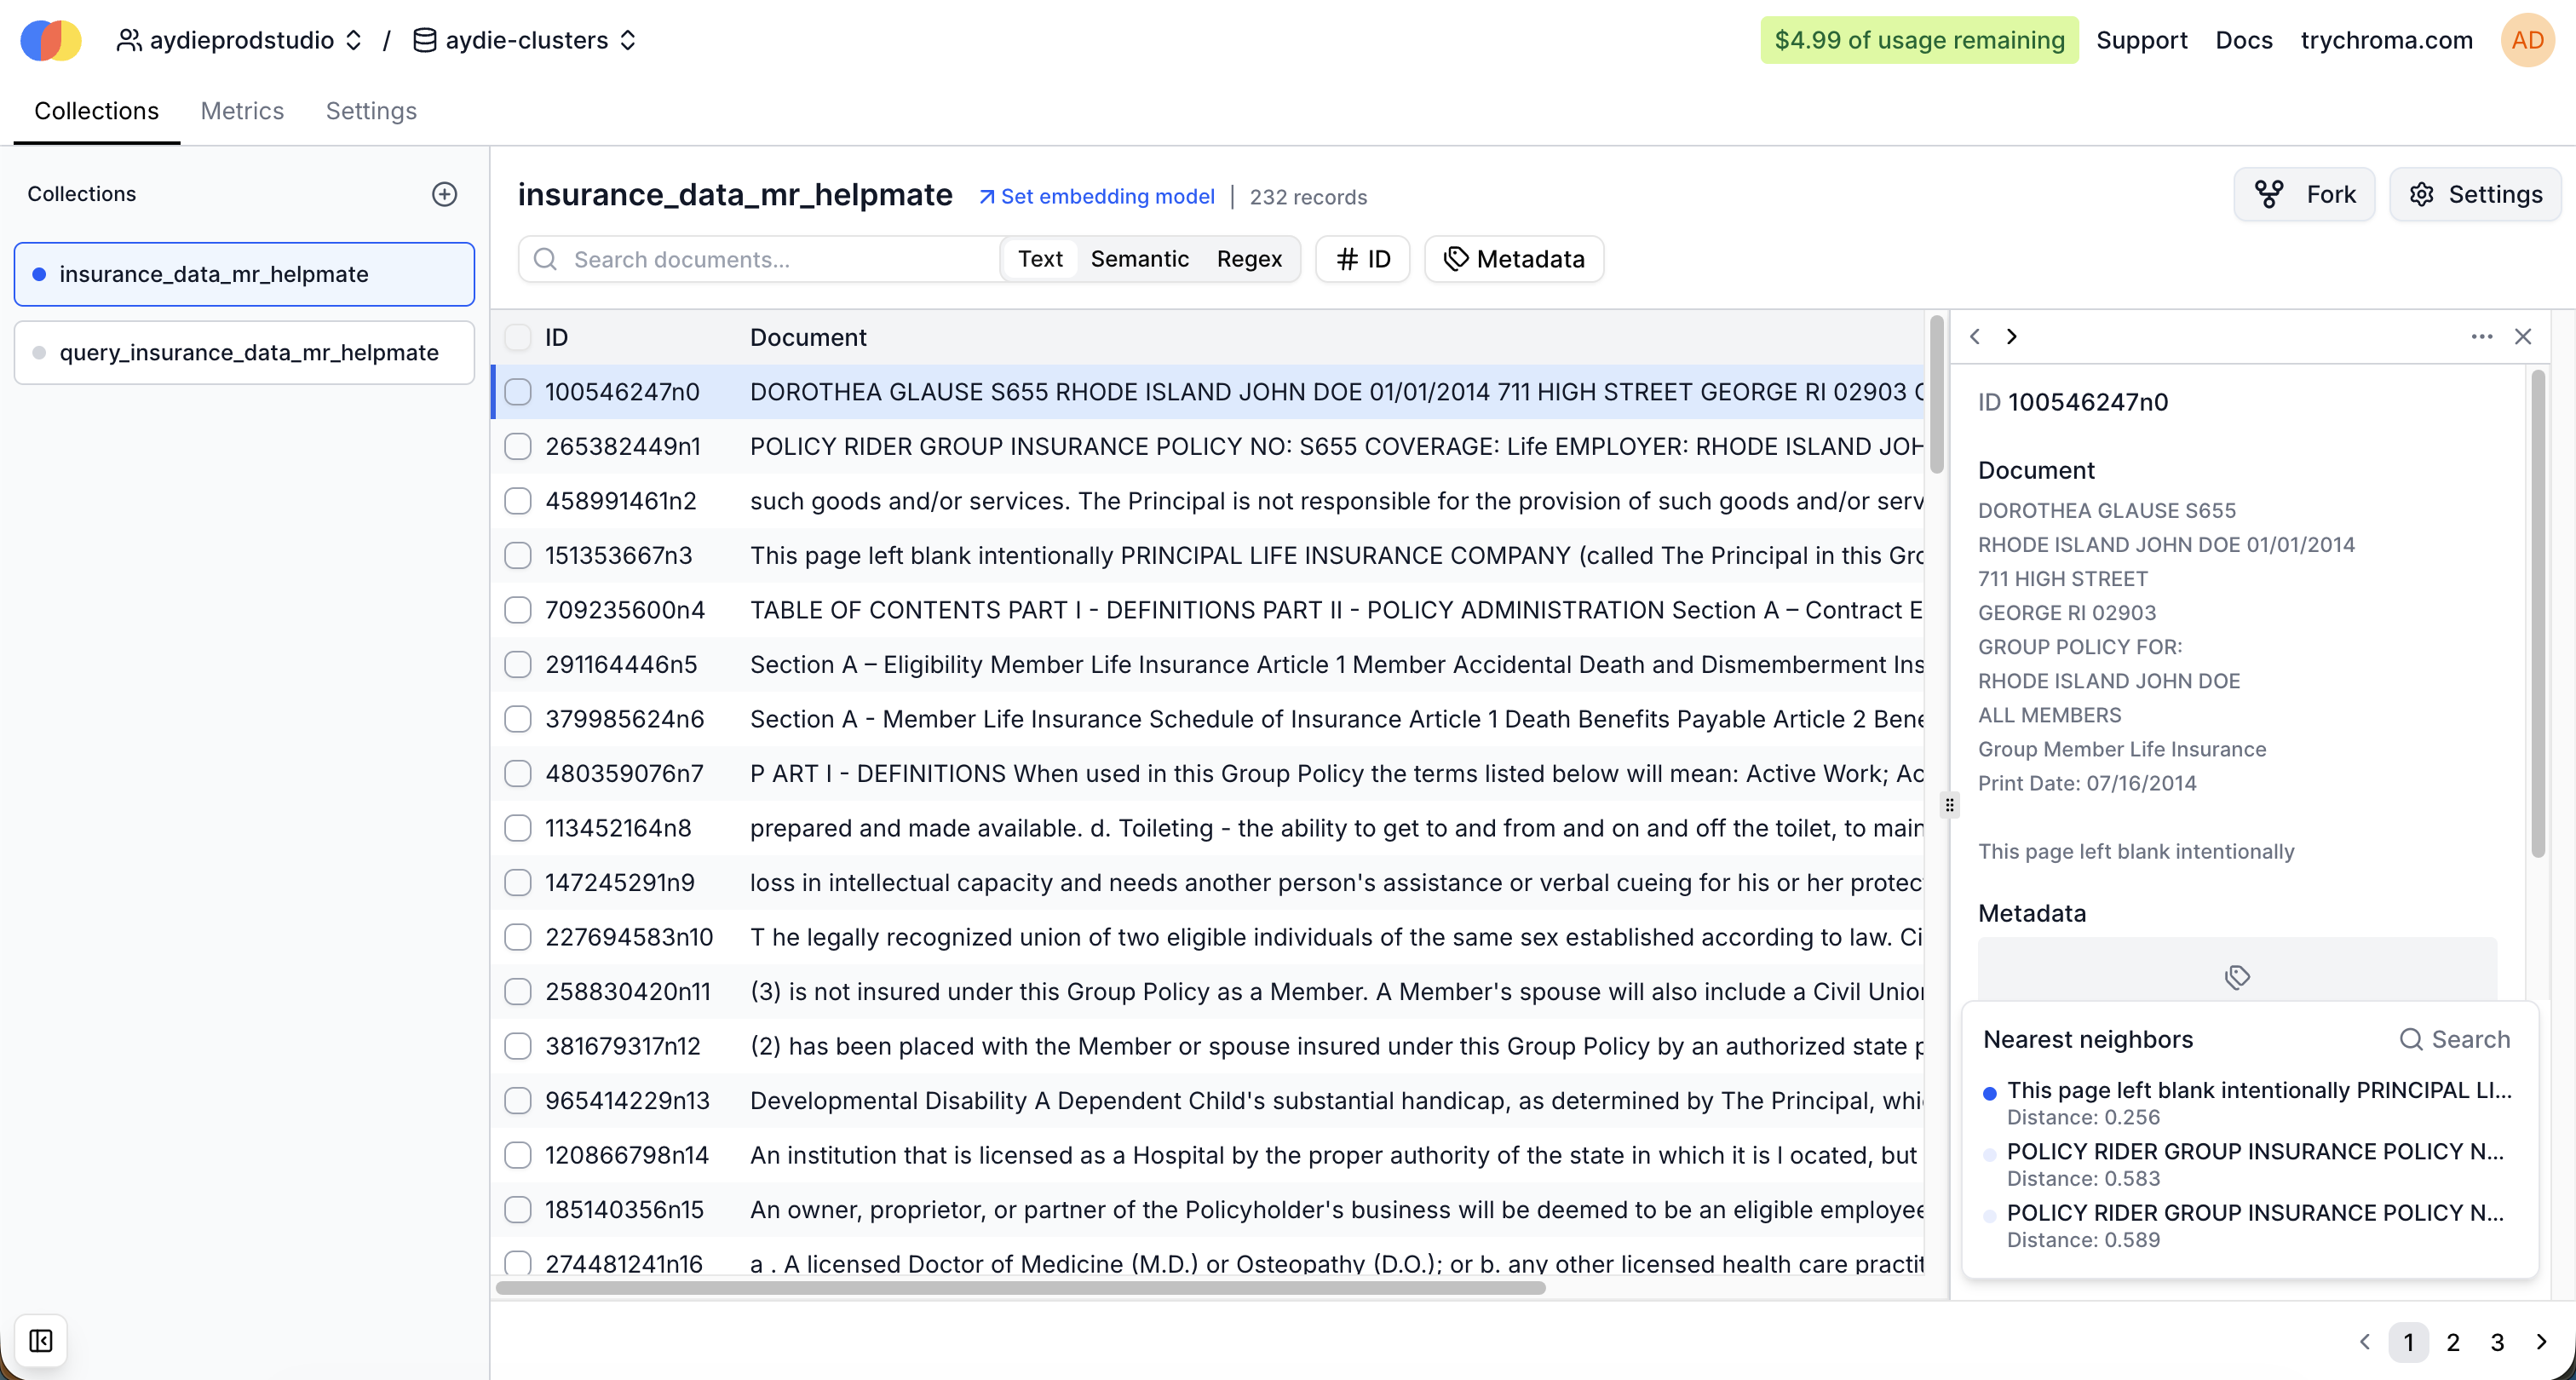

![Screenshot 2025-10-08 at 19.27.43.png](<attachment:Screenshot 2025-10-08 at 19.27.43.png>)
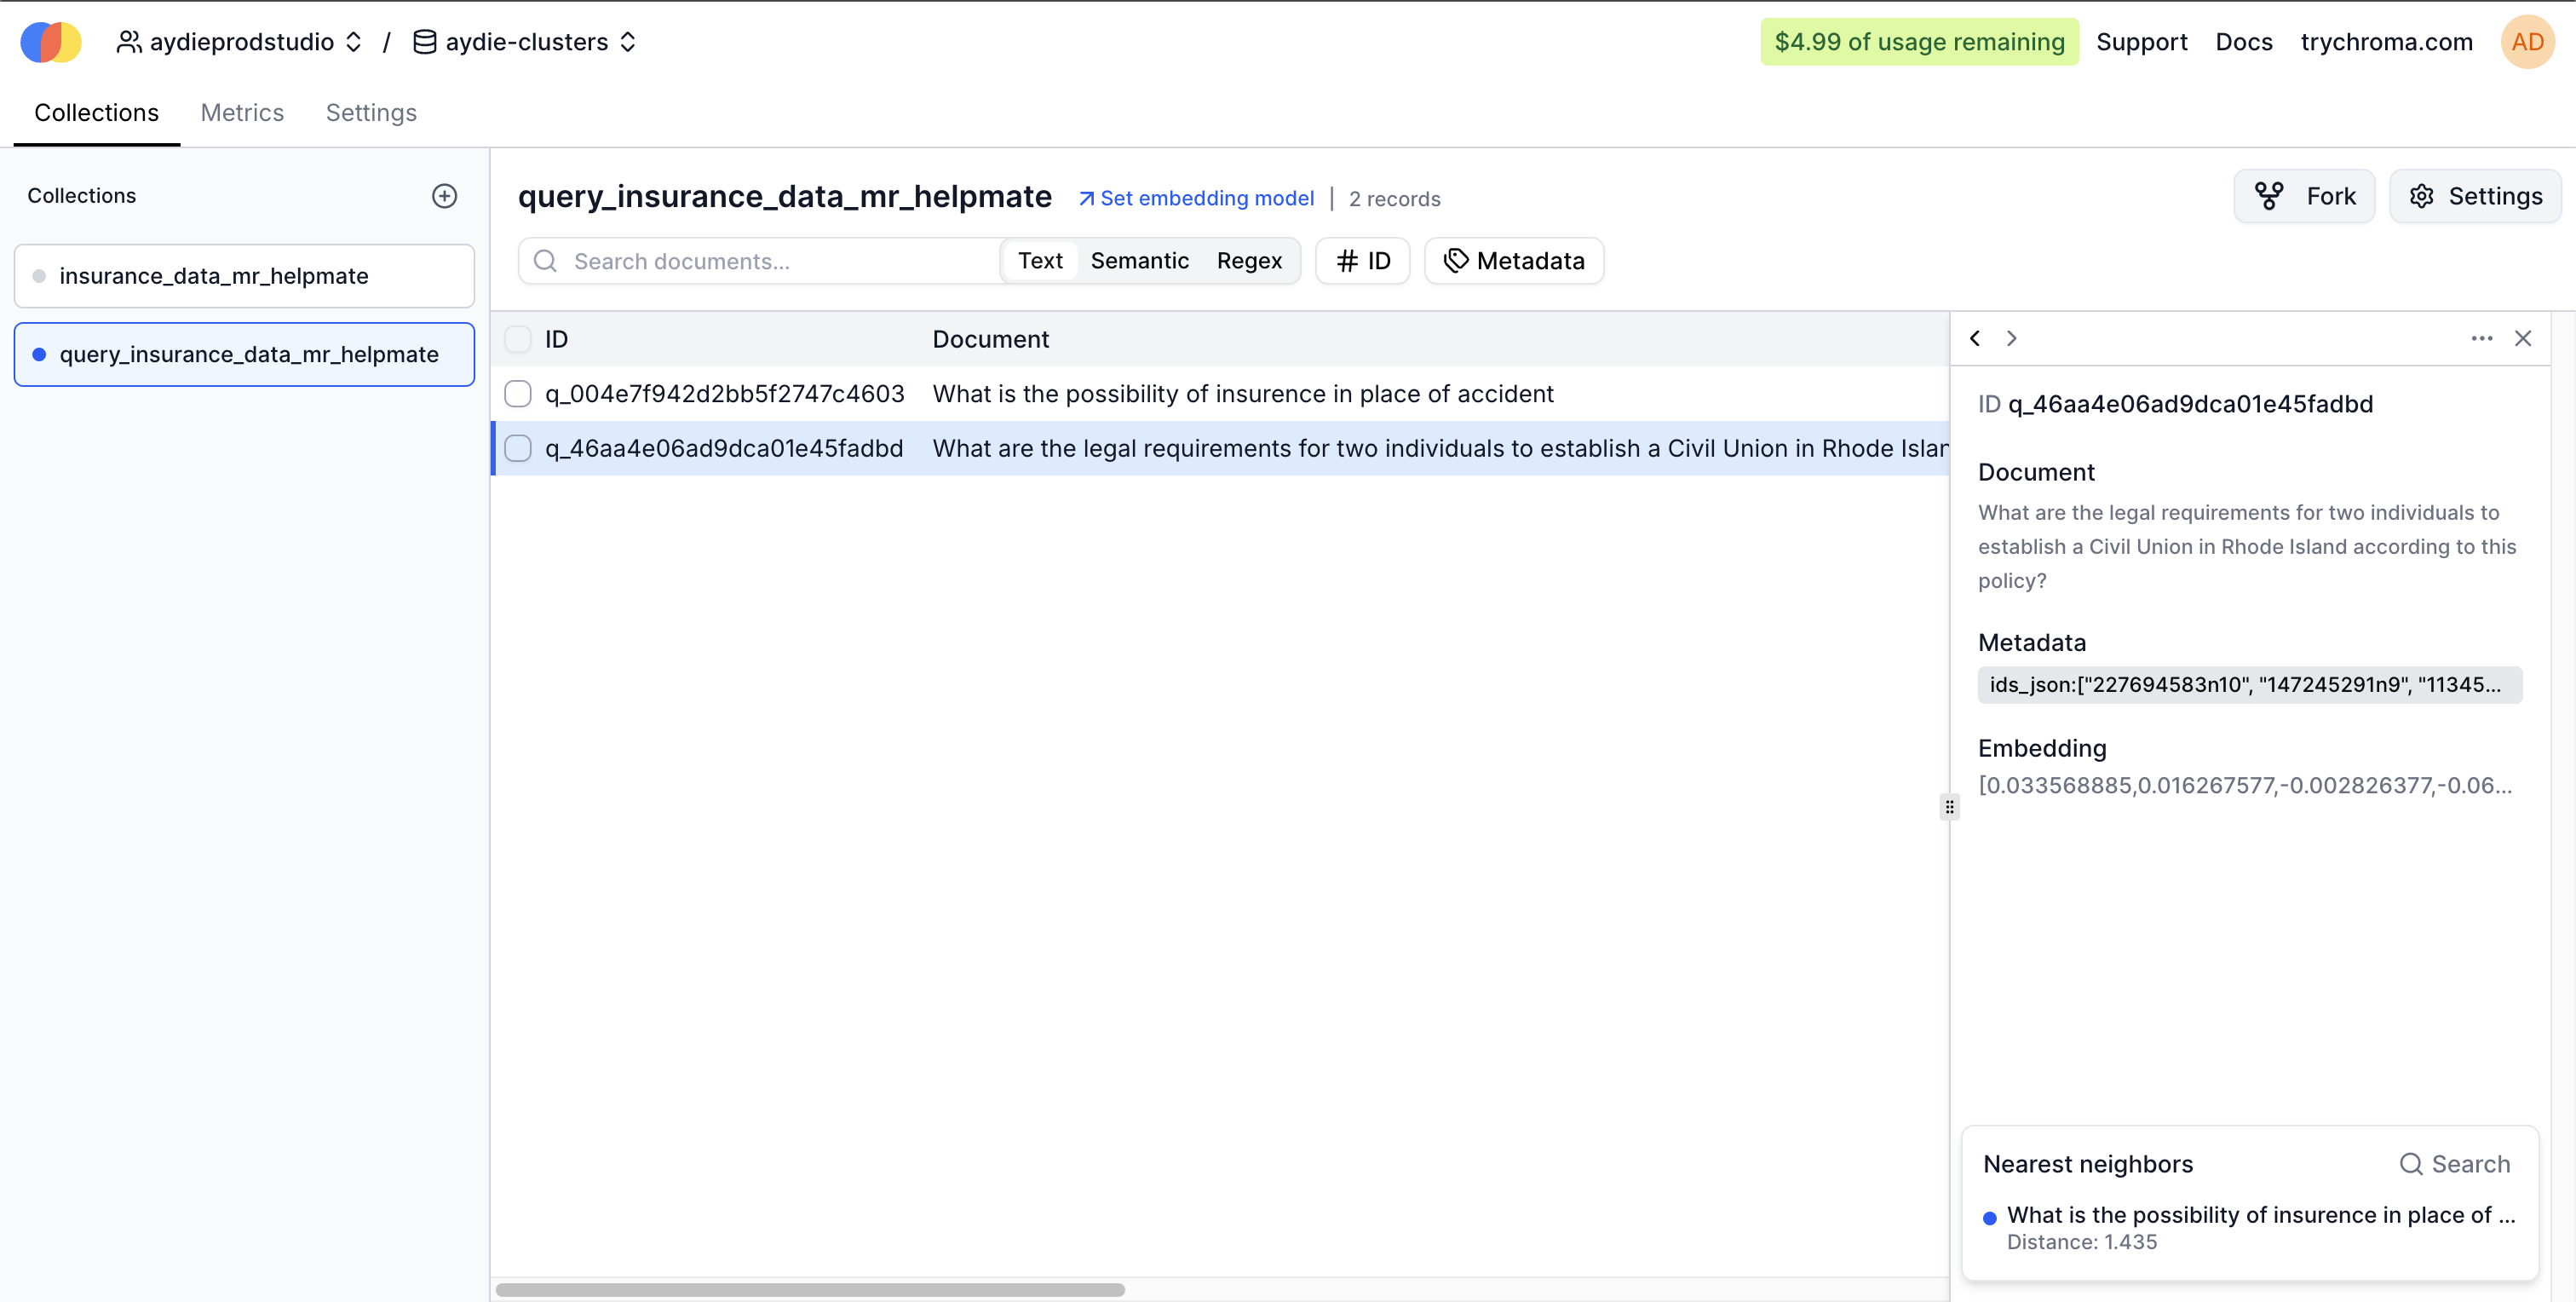

## It checks cache and retrives the information

## Rerank Layer

In [20]:
from src.backend.reranker import Reranker

reranker = Reranker()
ranked_with_cross_encoder = reranker.rerank_documents(
    documents=response_top_10['documents'],
    embeddings=response_top_10['embeddings'],
    query=query,
    top_k=3,
    cross_encoder=True
    )

In [21]:
print("Ranked with corss encoder: ")
for score, doc in ranked_with_cross_encoder:
    print(score, "\n", doc[:250], end="\n\n")

Ranked with corss encoder: 
-1.4954156 
 T he legally recognized union of two eligible individuals of the same sex established according to
law.
Civil Union Partner
For two persons to establish a Civil Union in Rhode Island, it shall be necessary that they satisfy
all of the following crite

-5.046482 
 or any regulation issued by any governmental agency to which this Group Policy is subject.
b. Any or all provisions of this Group Policy may be amended or changed at any time when
The Principal determines that such amendment is required for consisten

-5.2212763 
 (3) is not insured under this Group Policy as a Member.
A Member's spouse will also include a Civil Union Partner.
b. A Member's Dependent Child (or Children) as defined below.
Dependent Child; Dependent Children
a. A Member's natural child or stepch



## Moderation and Intent Layer

In [22]:
from src.backend.intent_moderation_check import (IntentCheck, ModerationCheck)

mod_chk = ModerationCheck()
int_cnf = IntentCheck()

question1 = "I want to kill a person."
question2 = "What are the legal requirements for two individuals to establish a Civil Union in Rhode Island according to this policy?"

print("Moderation Check for: ", question1, " => ", "Content is Flagged! True" if mod_chk.check_moderation(input_message=question1) else "Content is Not-flagged")
print("Moderation Check for: ", question2, " => ", "Content is Flagged! True" if mod_chk.check_moderation(input_message=question2) else "Content is Not-flagged")

print()

print("Checking Intent is matching: ", question1, " => ", "Intent is matching. True" if int_cnf.check_intent(input_message=question1) else "Intent is not matching.")
print("Checking Intent is matching: ",question2, " => ", "Intent is matching. True" if int_cnf.check_intent(input_message=question2) else "Intent is not matching.")

Moderation Check for:  I want to kill a person.  =>  Content is Flagged! True
Moderation Check for:  What are the legal requirements for two individuals to establish a Civil Union in Rhode Island according to this policy?  =>  Content is Not-flagged

Checking Intent is matching:  I want to kill a person.  =>  Intent is not matching.
Checking Intent is matching:  What are the legal requirements for two individuals to establish a Civil Union in Rhode Island according to this policy?  =>  Intent is not matching.


## Chatbot Conversation

In [31]:
from src.backend.generation_layer import ChatCompletion
from src.artifacts import SystemInstruction
from src.backend.intent_moderation_check import (IntentCheck, ModerationCheck)
from src.database.chromadb_vectorstore import VectorStore
from src.backend.reranker import Reranker



mod_chk = ModerationCheck()
int_cnf = IntentCheck()
chat_completion = ChatCompletion()
vector_store = VectorStore()
reranker = Reranker()

messages = [
    {"role": "system", "content": SystemInstruction.prompt}
]

while True:
    input_message = input("User: ")
    if input_message in ["exit", "bye", "end"]:
        print("Thank you for your time, hope I helped. Bye!")
        print("Chat Terminated....")
        break
    print("User:", input_message)
    
    if mod_chk.check_moderation(input_message=input_message):
        print("Your Conversation has been flagged!, restarting the conversation.")
        continue
    
    if int_cnf.check_intent(input_message=input_message):
        top_10_documents = vector_store.query_from_db(query=input_message,
                                                  top_k=10)
    
        reranked_top_3 = reranker.rerank_documents(documents=top_10_documents['documents'],
                                                   query=input_message,
                                                   top_k=3)
        
        reranked_context = ""
        for score, doc in reranked_top_3:
            reranked_context += doc + "\n\n\n"
        
        messages.append({
            "role": "user", "content": input_message + f"###context:\n" + reranked_context
        })
        
        ai_response = chat_completion.chat_completion(messages=messages)
        if mod_chk.check_moderation(input_message=ai_response):
            print("Your Conversation has been flagged!, restarting the conversation.")
            continue
        
        print("Assistant: ", ai_response)
        print("\n\n")
        
    else:
        print("Your question is out of scope or context, please ask the right question related to the domain.")
        continue

User: What are possible insurance plan inplace of accident?
Assistant:  The context mentions the following insurance plans that relate to accidents or injuries:

*   **Member Life Insurance**: This insurance may be continued if active work ends due to injury. If death occurs while Coverage During Disability is in force, the Member Life Insurance benefit would be paid.
*   **Member Accidental Death and Dismemberment Insurance**: Premiums for this insurance are not charged while Coverage During Disability is in force.



User: under what conditions is a Member considered to have an Activities of Daily Living (ADL) Disability, and what specific abilities are included as Activities of Daily Living?
Assistant:  A Member is considered ADL Disabled if, due to sickness or injury, they have lost the ability to safely and completely perform two or more Activities of Daily Living without another person's assistance or verbal cueing. Alternatively, a Member is considered ADL Disabled if they have 